In [1]:
scClass_path = !cd ../scClass_modelA;pwd
scClass_path = str(scClass_path.n)
import sys; sys.path.append(scClass_path)
import scClass
from scClass.main import Model

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd

In [3]:
bm_dataset_path = "../dataset/BoneMarrow.h5ad"
cb_dataset_path = "../dataset/CordBlood.h5ad"
adata_bm = scClass.read_h5ad(bm_dataset_path)
adata_cb = scClass.read_h5ad(cb_dataset_path)
adata_bm.obs_names_make_unique()
adata_cb.obs_names_make_unique()
adata_bm.var_names_make_unique()
adata_cb.var_names_make_unique()
adata = scClass.sc.AnnData.concatenate(adata_bm,adata_cb)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/shhsu/.local/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD113-1', 'SNORD113-2']
  warnings.warn(


In [4]:
matrix,label = adata.X,adata.obs['modelA id'] 
matrix,label = scClass.random(matrix,label,seed=0)

kick type_id=-1 cell from 547722 cells to 485919 cells


In [5]:
# subsmapling
label_tmp = np.array([],dtype=int)
for i in np.unique(label):
    msum2 = np.array(matrix.sum(axis=1)).flatten()
    msum2[label!=i] = -1
    label_tmp = np.append(label_tmp,np.argsort(msum2)[::-1][:1000])
matrix_sub = matrix[label_tmp,:]
label_sub = label[label_tmp]

In [6]:
unique = np.unique(label_sub,return_counts=True)
pd.DataFrame(unique)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,1,2,3,4,5,6,7,8,9,10,11,12
1,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000


In [7]:
adata_sub = sc.AnnData(X=matrix_sub,obs={'modelA id':label_sub.values})

In [8]:
adata_sub = scClass.normalize_simple(adata_sub)
matrix_sub,label_sub = scClass.random(adata_sub.X,adata_sub.obs['modelA id'],seed=0)

kick type_id=-1 cell from 13000 cells to 13000 cells


In [9]:
dataset = scClass.npz_dataloader(matrix_sub,label_sub)

loading data, it will take time


In [10]:
model = scClass.Model()

In [11]:
scClass.training(dataset,model)

0 
epoch 0 	| loss:2.34044671 | training accuracy:0.22300000| loss:2.42168880 | validation accuracy:0.22307692
0 
epoch 1 	| loss:1.65033460 | training accuracy:0.57100000| loss:1.81524861 | validation accuracy:0.49653846
0 
epoch 2 	| loss:1.45052922 | training accuracy:0.53600000| loss:1.51563239 | validation accuracy:0.51923077
0 
epoch 3 	| loss:0.94445342 | training accuracy:0.67400000| loss:1.09842157 | validation accuracy:0.62076923
0 
epoch 4 	| loss:0.71965581 | training accuracy:0.73600000| loss:0.81749278 | validation accuracy:0.67961538
0 
epoch 5 	| loss:0.52361202 | training accuracy:0.80400000| loss:0.64147455 | validation accuracy:0.72769231
0 
epoch 6 	| loss:0.51734370 | training accuracy:0.84000000| loss:0.68940884 | validation accuracy:0.76423077
0 
epoch 7 	| loss:0.39633480 | training accuracy:0.90200000| loss:0.55295932 | validation accuracy:0.80615385
0 
epoch 8 	| loss:0.35200760 | training accuracy:0.90600000| loss:0.49369258 | validation accuracy:0.84038462
0

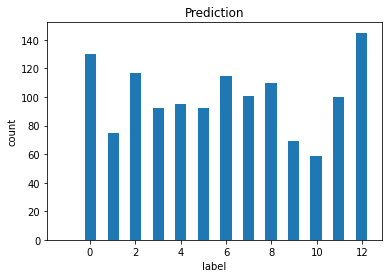

In [12]:
scClass.main.threshold = [np.NAN]*13
y_pred = scClass.predict_batch(dataset.test_x,model)

,label
-1,unknown
0,T-helper cell
1,cytotoxic T cell
2,memory B cell
3,naive B cell
4,plasma cell
5,precursor B cell
6,pro-B cell
7,natural killer cell
8,erythrocyte

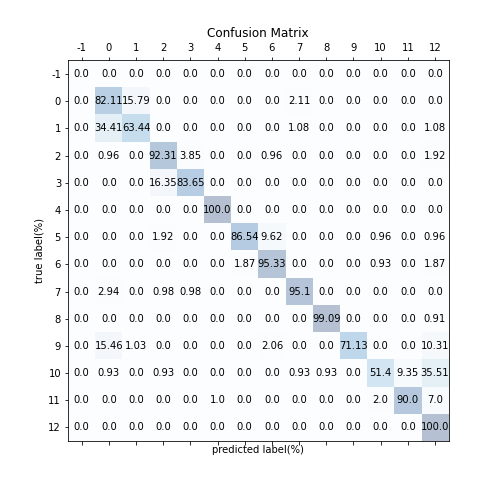

In [13]:
fig = scClass.confusion_matrix(y_pred=y_pred,y_true=dataset.test_y)
scClass.figure_html(fig)

In [14]:
scClass.plot_performance(y_pred,np.array(dataset.test_y))

,Performance,Value
0,accuary,0.853077
1,precision,0.853922
2,recall,0.874111
3,f1-score,0.850220


In [15]:
model.save()

model stored in: './output/model_20220126_212653.pkl'


## Classify

In [28]:
adata = sc.read_h5ad("../dataset/HTD_Thymic.h5ad")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [29]:
adata = adata[adata.obs['modelA id']!=-1,:]

In [30]:
gene = np.array([g[:15] for g in adata.var['ensembl_ids']])
adata = scClass.transmodel(adata,gene=gene,gene_ref='ensembl_ids')
adata = scClass.normalize_simple(adata)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


get gene seq...
0% 8% 17% 25% 34% 42% 51% 59% 68% 77% 85% 94% 
Of 58347 genes in the input file, 45471 were found in the training set of 45468 genes.
mapping to model...
0% 

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


0% 67% 

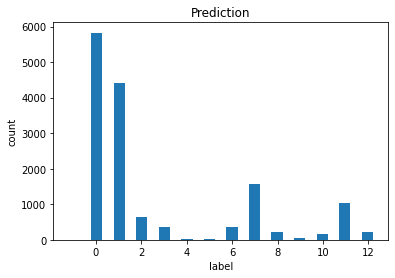

In [31]:
y_pred = scClass.predict_batch(adata,model,batch_size=10_000)

,label
-1,unknown
0,T-helper cell
1,cytotoxic T cell
2,memory B cell
3,naive B cell
4,plasma cell
5,precursor B cell
6,pro-B cell
7,natural killer cell
8,erythrocyte

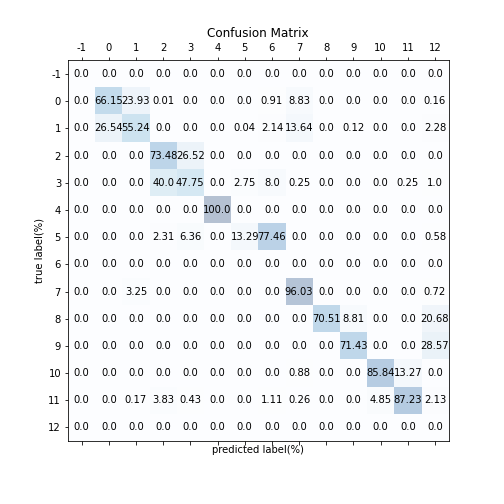

In [32]:
y_true = adata.obs['modelA id'].values 
fig = scClass.confusion_matrix(y_pred=y_pred,y_true=y_true)
scClass.figure_html(fig)

In [33]:
y_pred[y_pred==6] = 5 # pre/pro B Cell
scClass.plot_performance(y_pred,y_true)

,Performance,Value
0,accuary,0.650198
1,precision,0.767654
2,recall,0.652503
3,f1-score,0.666800
